In [1]:
import agentpy as ap
import networkx as nx
import random

import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [2]:
class Person(ap.Agent):
    
    def setup(self):
        """
        Iinitialize a new variable at agent creation. 
        """
        self.condition = 0 #Susceptible = 0, Infected = 1, Recovered = 2
        
    def being_sick(self):
        """
        Spread disease to peers in the network. 
        """
        rng = self.model.random
        for n in self.network.neighbors(self):
            if n.condition == 0 and self.p.infection_chance > rng.random():
                n.condition = 1 #Infect susceptible peer
        if self.p.recovery_chance > rng.random():
            self.condition = 2 #Recover from infection


In [3]:
class VirusModel(ap.Model):
    
    def setup(self):
        """
        Initialize the agents and network of the model. 
        """
        
        #Prepare a small-world network
        graph = nx.watts_strogatz_graph(self.p.population, self.p.number_of_neighbors, self.p.network_randomness)
        
        #Create agents and network
        self.agents = ap.AgentList(self, self.p.population, Person)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)
        
        #Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1
        
    def update(self):
        """
        Record variables after setup and each step. 
        """
        
        #Record share of agents with each condition
        for i, c in enumerate(("S", "I", "R")):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population
            self.record(c)

        #Stop simulation if disease is gone
        if self.I == 0:
            self.stop()
            
    def step(self):
        """
        Define the models' events per simulation step. 
        """
        
       #Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()
        
    def end(self):
        """
        Record evaluation measures at the end of the simulation. 
        """
        
        #Record final evaluation measures
        self.report("Total share infected", self.I + self.R)
        self.report("Peak share infected", max(self.log["I"]))

In [4]:
parameters = {
    "population": 1000, 
    "infection_chance": 0.3,
    "recovery_chance": 0.1,
    "initial_infection_share": 0.1,
    "number_of_neighbors": 2,
    "network_randomness": 0.5
}

model = VirusModel(parameters)
results = model.run()

Completed: 82 steps
Run time: 0:00:00.091019
Simulation finished


In [5]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 83 rows
'reporters': DataFrame with 3 variables and 1 row
}

**Visualisation of the variables over time**

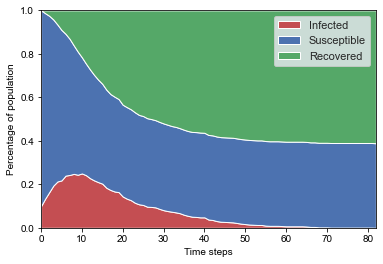

In [6]:
def virus_stackplot(data, ax):
    """
    Stackplot of people's condition over time. 
    """
    
    x = data.index.get_level_values("t")
    y = [data[var] for var in ["I", "S", "R"]]
    
    sns.set()
    ax.stackplot(x, y, labels = ["Infected", "Susceptible", "Recovered"], colors = ["r", "b", "g"])
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x) - 1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")
    
fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

**Creating an animation**

In [7]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")
    
    #Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)
    
    #Plot network on second axis
    color_dict = {0:"b", 1:"r", 2:"g"}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color = colors, node_size=50, ax  =ax2)
    
fig, axs = plt.subplots(1, 2, figsize = (8, 4)) # Prepare figure
parameters["population"]  = 50 # Lower population for better visibility
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

In [8]:
IPython.display.HTML(animation.to_jshtml())

**Multi-run Experiment**

In [10]:
parameters = {
    "population": ap.IntRange(100, 1000),
    "infection_chance": ap.Range(0.1, 1.),
    "recovery_chance": ap.Range(0.1, 1.),
    "initial_infection_share": 0.1,
    "number_of_neighbors": 2,
    "network_randomness": ap.Range(0., 1.)    
}

sample = ap.Sample(
    parameters,
    n = 128,
    method = "saltelli",
    calc_second_order = False
)

In [11]:
exp = ap.Experiment(VirusModel, sample, iterations = 10)
results = exp.run()

Scheduled runs: 7680
Completed: 7680, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:03:15.487848


In [12]:
results.save()

Data saved to ap_output/VirusModel_1


In [13]:
results = ap.DataDict.load("VirusModel")

Loading from directory ap_output/VirusModel_1/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


In [14]:
results

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'log': Dictionary with 5 keys
    'sample': DataFrame with 4 variables and 768 rows
'reporters': DataFrame with 3 variables and 7680 rows
}

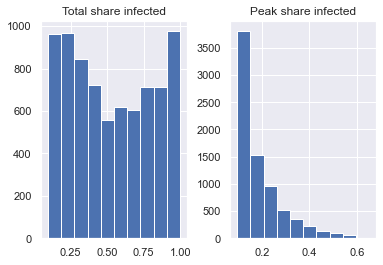

In [16]:
results.reporters.hist();

**Sensitivity Analysis**

In [18]:
results.calc_sobol()

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'log': Dictionary with 5 keys
    'sample': DataFrame with 4 variables and 768 rows
'reporters': DataFrame with 3 variables and 7680 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 8 rows
    'sobol_conf': DataFrame with 2 variables and 8 rows
}

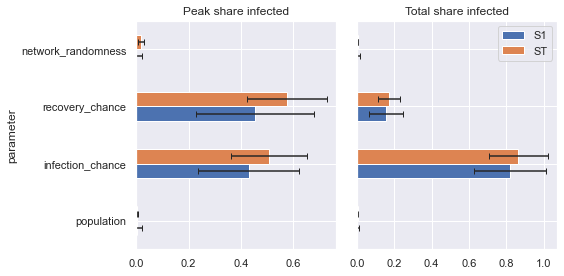

In [19]:
def plot_sobol(results):
    """
    Bar plot of Sobol sensitivity indices. 
    """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by="reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby(by="reporter")
    
    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr = err, title = key, ax = ax, capsize = 3)
        ax.set_xlim(0)
        
    axs[0].get_legend().remove()
    axs[1].set(ylabel = None, yticklabels = [])
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

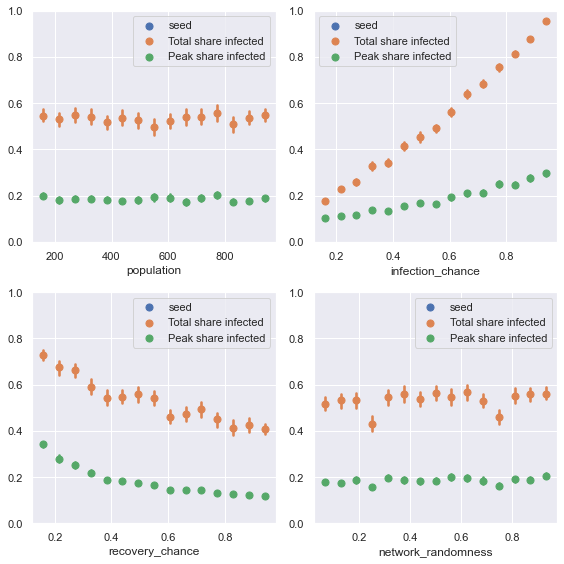

In [21]:
def plot_sensitivity(results):
    """
    Show average simulation results for different parameter values. 
    """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize = (8, 8))
    axs = [i for j in axs for i in j] #Flatten list
    
    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(0, 1)
        ax.set_ylabel("")
        ax.legend()
        
    plt.tight_layout()
    
plot_sensitivity(results)